# Load data

In [1]:
# Import libraries
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
#from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib import gridspec
#import plotly.express as px
from Functions import SB_Albanese2020, add_accents
import pandas as pd 
import numpy as np
import datetime 
#import imageio
import os
pd.set_option('display.max_colwidth', None)

/home/sebastian/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv('../MediaSharingIndex/Data/data.csv')
df.head(n = 5)

,date,url,outlet,dynamic_opinion,tid,uid,hour,date_url,title,pos_CL,...,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,3123001870860070177,-5290478328161710131,02:02:20,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,1161354566247419187,1984147057615254567,02:02:04,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,-8265852459726288982,907971274336289915,02:16:55,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,2424256138563082008,-1315437987437732754,02:16:21,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,-8244136094798448801,6507777798650809238,02:28:17,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0


In [3]:
# Group and count articles in the main DataFrame by 'outlet' and sort descending
dfg = df.groupby('outlet').count().sort_values(by='tid', ascending=False).reset_index()

# Define the main outlets as the first 6 that are most frequently shared:
print('dfg: \n', dfg[['outlet','tid']].rename(columns = {'tid':'# tweets'}).head(6))
main_outlets = dfg['outlet'][0:6].to_list()

dfg: 
           outlet  # tweets
0     El Destape    307021
1         Clarin    160226
2        Infobae    141902
3      La Nacion    104183
4  Todo Noticias     95286
5      Pagina 12     76274


# Calculate Sentiment Bias (SB)

## SB by news articles

Calculate the sentiment bias (SB) of the news articles

In [4]:
df['SB'] = df.apply(lambda row: SB_Albanese2020(row), axis = 1)

Dinamic model of votting: We choose the intention of votting as the label for each tweet

Most important topic:

In [5]:
df['Topic'] = df[[f'T{t}' for t in range(10)]].apply(lambda x: np.argmax(x), axis = 1)

In [6]:
data = df.copy()
data.drop_duplicates('url', inplace=True)
# News articles with SB
data_with_sentiment = data.dropna(subset = ['SB'])

## Mean SB by topic

Two ways:

1) Weighted average
2) Assigning to each article the most important topic

#### 1. Weighted average

In [7]:
for t in range(10):
    ans = np.average(data_with_sentiment['SB'], weights=data_with_sentiment[f'T{t}'].to_numpy())
    print(f'T{t}', ans)

T0 -0.05644334023148842
T1 -0.0694844591751829
T2 0.040785706572236555
T3 0.035920841482214194
T4 -0.0559269162310333
T5 -0.11205463504566897
T6 -0.10288066541321059
T7 -0.05583833816296598
T8 -0.011374661292663206
T9 -0.02700975874135144


2. Assigning to each article the most important topic

In [8]:
data_with_sentiment.groupby('Topic')['SB'].mean()

Topic
0   -0.065763
1   -0.076073
2    0.055368
3    0.054425
4   -0.056597
5   -0.138060
6   -0.115794
7   -0.048496
8    0.014568
9   -0.017879
Name: SB, dtype: float64

The two ways are very similar.

### SB per topic

In [9]:

sb_estimated = [np.average(data_with_sentiment['SB'], weights=data_with_sentiment[f'T{t}'].to_numpy()) for t in range(8)]

Bootstrapping:

In [10]:
sb_bootstrapped = []
for iteration in range(1000):
    
    sample = data_with_sentiment.sample(n=data_with_sentiment.shape[0], replace = True)
    sb_bootstrapped.append([np.average(sample['SB'], weights=sample[f'T{t}'].to_numpy()) for t in range(8)])

In [11]:
q025, q975 = np.quantile(np.array(sb_bootstrapped), q = [0.005, 0.995], axis = 0)

Figure:

In [12]:
topic_names = ['Politics BA Province', 'Economy/Dolar', 'Justice', 'Politics CL', '3rd Party', 'Wage/Inflation', 'Politics CR', 'Elections', 'Trash topic', 'Gossip & Sport']
topic_names = topic_names[:len(sb_estimated)]

In [13]:
len(topic_names)

8

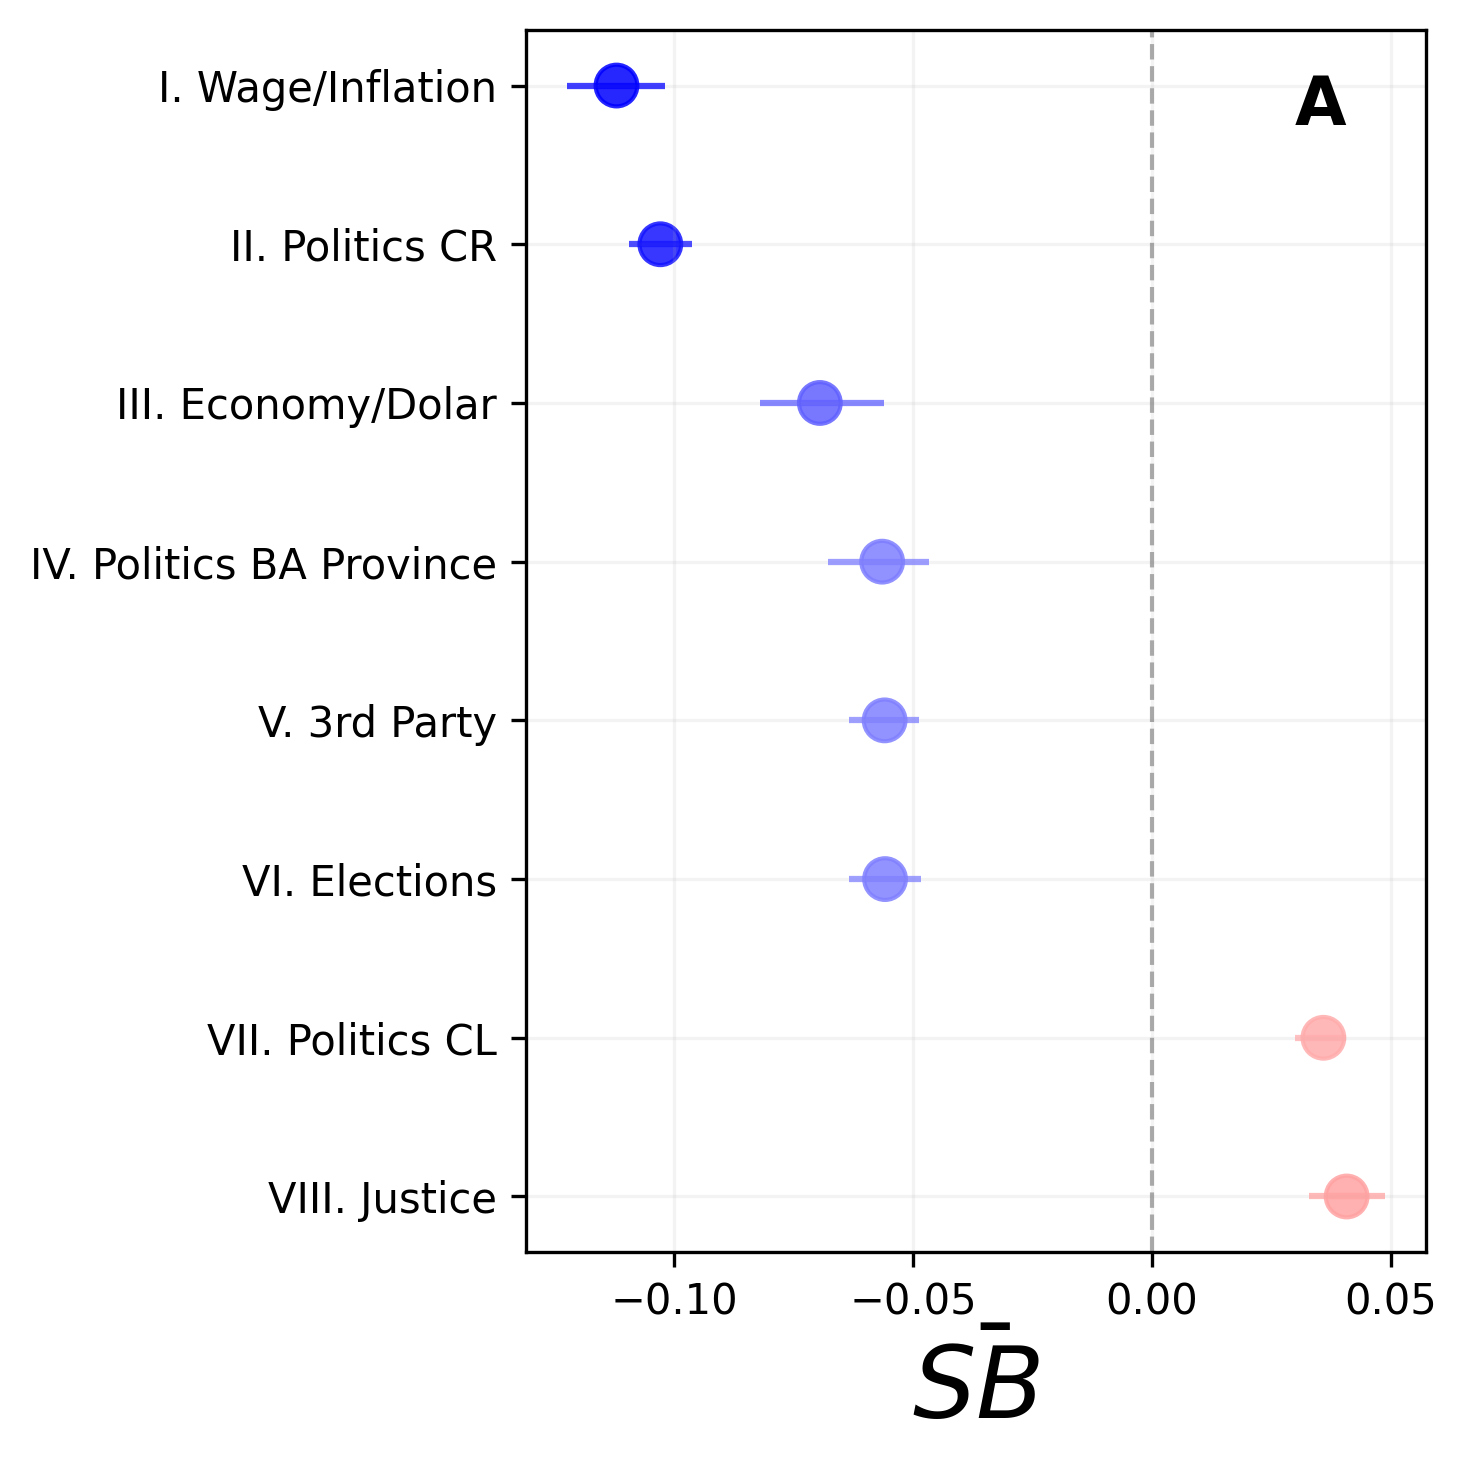

In [28]:
# Create the subplots
fig, ax1 = plt.subplots(figsize=(5,5),dpi = 300)

# Scale of colors where SB = 0 is white and the most extreme case has the most extreme color
colors = plt.cm.bwr((-0.5 * np.array(sorted(sb_estimated, reverse = True)) / np.array(sb_estimated).min() + 0.5))

ax1.scatter(sorted(sb_estimated, reverse = True), range(len(sb_estimated)), c=colors, s = 100, alpha = 0.85)

k = 0
for i in sorted(range(len(sb_estimated)), reverse = True, key = lambda x: sb_estimated[x]):
    ax1.hlines(y = k, xmin=q025[i], xmax=q975[i], color = colors[k], alpha = 0.75)
    k += 1

ax1.set_yticks(range(len(sb_estimated)))

roman_numbers = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII']

ytick_labels = [topic_names[i] for i in sorted(range(len(sb_estimated)), reverse = True, key = lambda x: sb_estimated[x])]
ax1.set_yticklabels([roman_numbers[-i-1] + '. ' + ytick_labels[i] for i in range(len(ytick_labels))])

ax1.axvline(0, linestyle = '--', color = 'grey', linewidth = 1, alpha = 0.65, label = r'$\bar{SB}=0$')

plt.xlabel(r'$\bar{SB}$', size = 24)
plt.grid(True, alpha = 0.15)
plt.text(0.03, 6.75, "A", fontweight = 'bold',fontsize = 16)

plt.tight_layout()
plt.savefig('New_figure4a.png')
plt.show()